In [1]:
%%time
# for development, changes in other modules have to be reloaded to reflect changes
%load_ext autoreload
%autoreload 1

import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sbn 
import os, sys
import SimpleITK as sitk

%aimport config 
sys.path.append(config.lib_dir)
%aimport utils
%aimport segment 
%aimport match 
%aimport register 
%aimport evaluate 
%aimport qc 
sys.path.append(config.script_dir)
from slide_registration import *

CPU times: user 812 ms, sys: 703 ms, total: 1.52 s
Wall time: 2.23 s


# Overview

The goal of this notebook is to compare the efficacy of the full slide's registrations for a given experiment.


In [2]:
# These must be adjusted to your specific experiment
unreg_path    = '/mnt/z/Marilyne/Axioscan/5_Pejovic/Tiffs/Registration/'
reg_path      = './registered_imgs/'
slide_name    = 'S3'
scene_name    = 'Scene-1'

In [3]:
img_file_names = [x for x in os.listdir(reg_path) if x[-4:] == '.tif']
parsed_names = pd.DataFrame([parse_file_name(x) for x in img_file_names])

# filter to slide/scene
parsed_names = parsed_names[lambda x: (x.slide_name == slide_name) & (x.scene == scene_name)]

# grab only the dapi channel 
parsed_names = parsed_names[lambda x: x.color_channel == 'c1']

parsed_names.head()

,round,protein,slide_name,date,scan_id,scene,color_channel,note,file_type,original
0,R0,AF488.AF555.AF647.AF750,S3,2020-01-21,13471,Scene-1,c1,ORG,tif,R0_AF488.AF555.AF647.AF750_S3_2020_01_21__1347...
5,R10,r10c2.CA9.pAKT.Ecad,S3,2020-02-05,13581,Scene-1,c1,ORG,tif,R10_r10c2.CA9.pAKT.Ecad_S3_2020_02_05__13581-S...
10,R11,r11c2.NCad.MMP9.pCHK2,S3,2020-02-06,13594,Scene-1,c1,ORG,tif,R11_r11c2.NCad.MMP9.pCHK2_S3_2020_02_06__13594...
15,R12,r12c2.Fibro.Sting.pP38,S3,2020-02-07,13611,Scene-1,c1,ORG,tif,R12_r12c2.Fibro.Sting.pP38_S3_2020_02_07__1361...
20,R13,r13c2.CD68.CD8.CD45,S3,2020-02-10,13644,Scene-1,c1,ORG,tif,R13_r13c2.CD68.CD8.CD45_S3_2020_02_10__13644-S...


In [4]:
imgs_reg = utils.load_imgs_mt(parsed_names.original.values, reg_path)

starting multithreaded image loading...
assigning threads...done.
waiting for threads to complete.
finished task: 7/166
threads complete.

...image loading complete.


In [5]:
imgs_unreg = utils.load_imgs_mt(parsed_names.original.values, unreg_path)

starting multithreaded image loading...
assigning threads...done.
waiting for threads to complete.
finished task: 13/16
threads complete.

...image loading complete.


# Evaluating slide registration

In [6]:
np.array(list(imgs_reg.keys()))[[('R0' in x and 'c1' in x) for x in imgs_reg.keys()]][0]

'R0_AF488.AF555.AF647.AF750_S3_2020_01_21__13471-Scene-1_c1_ORG.tif'

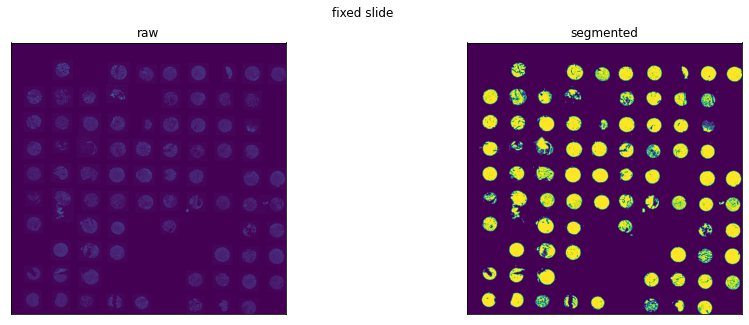

In [7]:
f,axes = plt.subplots(1,2, figsize=(15,5))

R0_name = np.array(list(imgs_reg.keys()))[[('R0' in x and 'c1' in x) for x in imgs_reg.keys()]][0]
fixed = imgs_reg[R0_name]

utils.myshow(fixed[::10, ::10], ax=axes.flat[0], title='raw')
seg_fixed = fixed > np.quantile(sitk.GetArrayFromImage(fixed), 0.85)
utils.myshow(seg_fixed[::10, ::10], ax=axes.flat[1], title='segmented')
plt.suptitle('fixed slide')

plt.show()

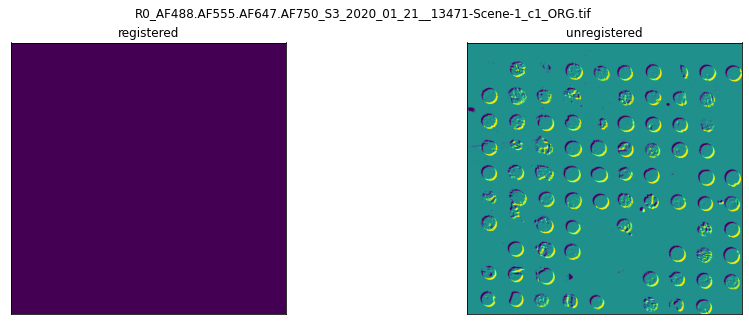

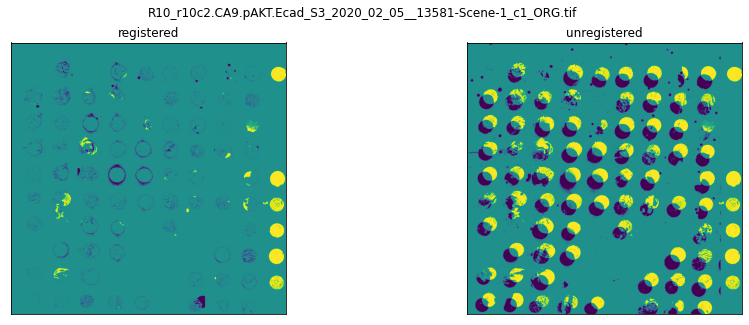

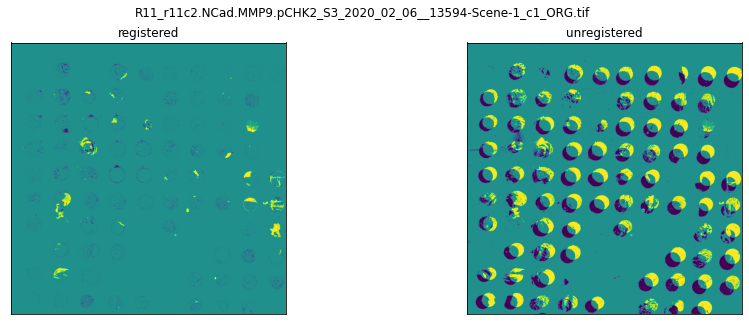

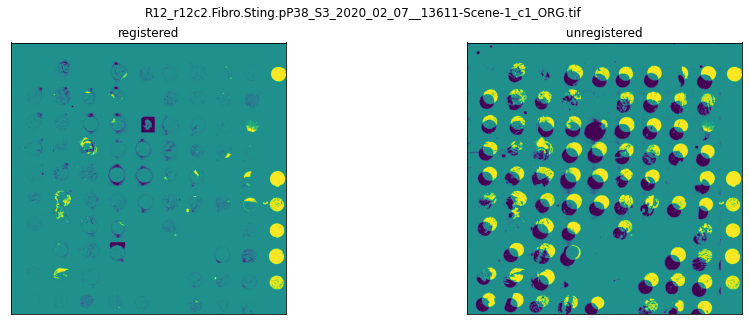

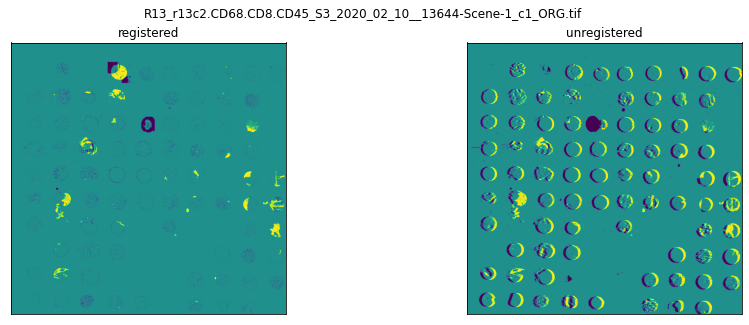

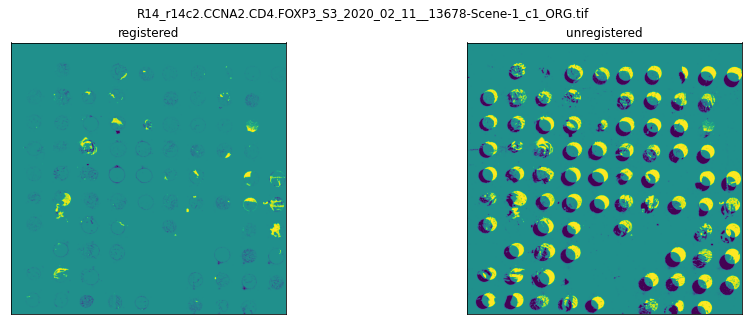

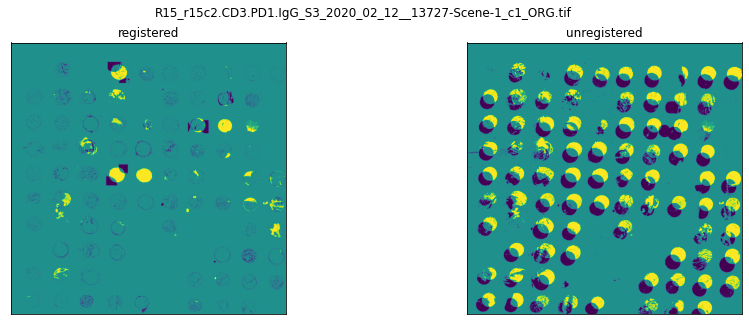

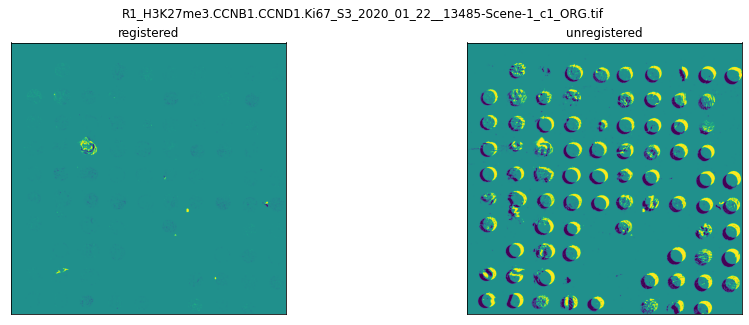

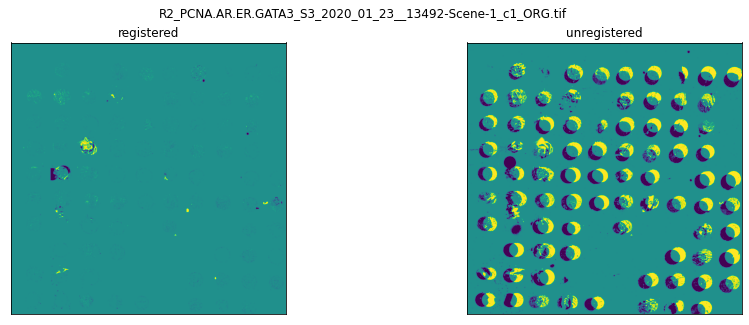

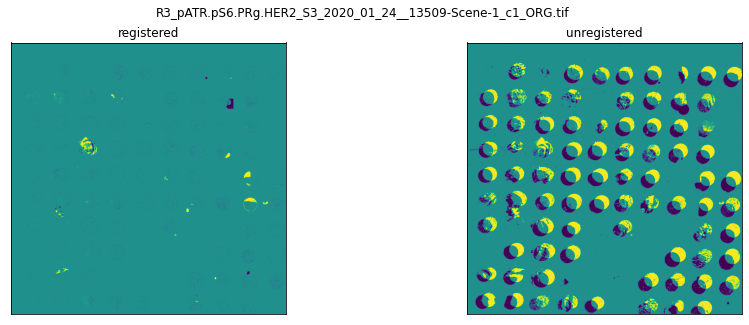

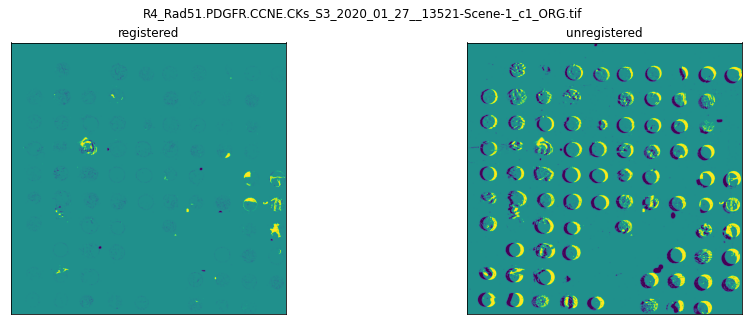

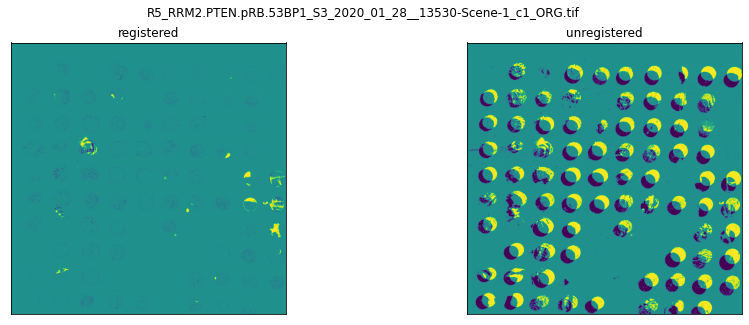

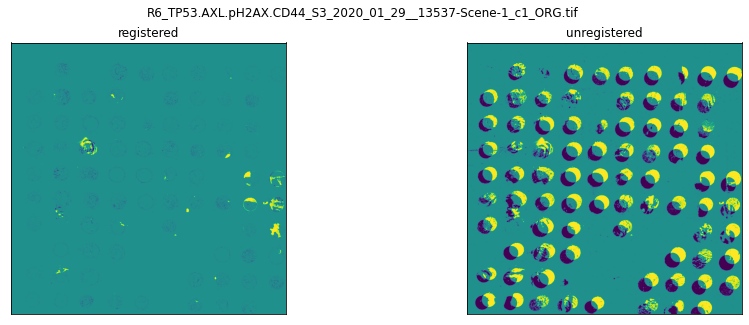

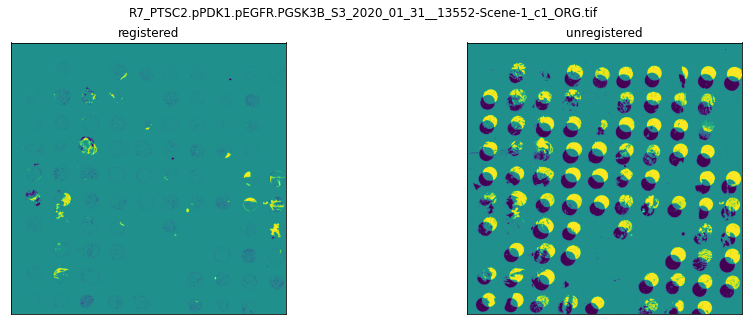

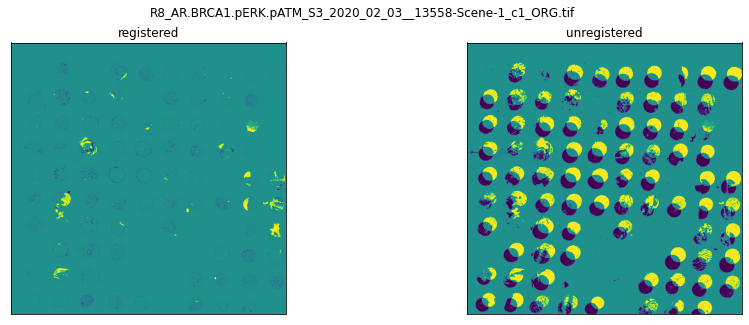

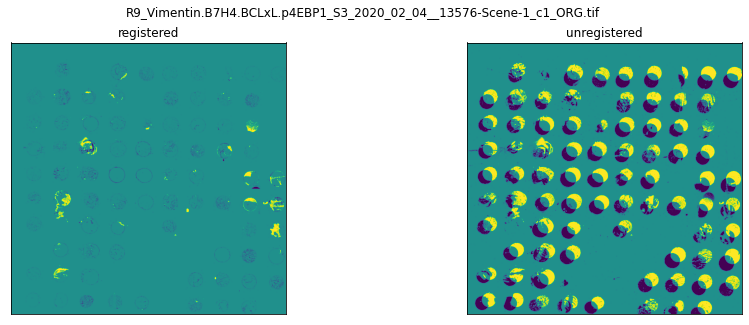

In [8]:
def plot_reg(moving, seg_fixed, ax, title): 
    
    #moving  = gaussian.Execute ( moving )
    #seg_fixed = fixed > np.quantile(fixed, 0.75)
    #seg_fixed = sitk.Cast(fixed, sitk.sitkInt8)
    seg_moving = moving > np.quantile(sitk.GetArrayFromImage(moving), 0.85)
    seg_moving = sitk.Cast(seg_moving, sitk.sitkInt8)
    seg_fixed = sitk.Cast(seg_fixed, sitk.sitkInt8)
    
    sub = seg_fixed - seg_moving
    utils.myshow(sub[::10, ::10], ax=ax, title=title)

im_names = list(imgs_reg.keys())
im_names.sort()
for _im in im_names: 
    #print(_im)
    moving_reg = imgs_reg[_im]
    moving_unreg = imgs_unreg[_im]
    
    moving_unreg = sitk.Resample(moving_unreg, seg_fixed)
    moving_reg = sitk.Resample(moving_reg, seg_fixed)
    
    f, axes = plt.subplots(1,2, figsize=(15,5))
    plot_reg(moving_reg, seg_fixed, axes.flat[0], 'registered')
    
    plot_reg(moving_unreg, seg_fixed, axes.flat[1], 'unregistered')
    plt.suptitle(_im)
    plt.show()